# Run panda repeater first  
```
ssh panda@192.168.0.172
roslaunch panda_ros_repeater joint_velocity_repeater.launch robot_ip:=192.168.0.13 load_gripper:=false
```

# initialize notebook

In [1]:
from __future__ import print_function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; } </style>"))
import matplotlib.pyplot as plt

# Initialize constants

In [2]:
from pkg.marker_config import *
from pkg.constraint_graph import *
from pkg.constraint.constraint_action import *
from pkg.constraint.constraint_object import *
from pkg.constants import *
from pkg.utils.plot_utils import *
from pkg.utils.utils import *
from pkg.environment_builder import *
from pkg.ui.ui_broker import *
from pkg.controller.combined_robot import *

gtimer = GlobalTimer.instance()
gtimer.reset()

In [3]:
crob = CombinedRobot(connection_list=(False, False))

connection_list
(False, False)


# initialize graph & ui

In [4]:
if "cam" not in locals():
    cam = StereoCamera.instance()

# set urdf
xcustom, JOINT_NAMES, LINK_NAMES, urdf_content = set_custom_robots(crob.robots_on_scene, XYZ_RPY_ROBOTS_DEFAULT, crob.joint_names)

# set graph
if "graph" in locals():
    graph.clear_markers()
    graph.clear_highlight()
    graph.ghnd.clear()
    graph.__init__(urdf_path=URDF_PATH, joint_names=JOINT_NAMES, link_names=LINK_NAMES, 
                   urdf_content=urdf_content, robots_on_scene=crob.get_dict(), )
    add_geometry_items(graph.urdf_content, color=(0, 1, 0, 0.3), display=True, collision=True,
                       exclude_link=["panda1_link7"])
else:
    graph = ConstraintGraph(urdf_path=URDF_PATH, joint_names=JOINT_NAMES, link_names=LINK_NAMES, 
                            urdf_content=urdf_content, combined_robot=crob)
    graph.set_camera(cam)
    graph.set_cam_robot_collision()
    graph.set_rviz()
    
    # start UI
    ui_broker = UIBroker(graph)
    ui_broker.start_server()
    
    # set rviz
    graph.set_rviz(crob.home_pose)
    ui_broker.set_tables()

Start streaming
Device configuration: 
	color_format: 3 
	(0:JPG, 1:NV12, 2:YUY2, 3:BGRA32)

	color_resolution: 5 
	(0:OFF, 1:720p, 2:1080p, 3:1440p, 4:1536p, 5:2160p, 6:3072p)

	depth_mode: 3 
	(0:OFF, 1:NFOV_2X2BINNED, 2:NFOV_UNBINNED,3:WFOV_2X2BINNED, 4:WFOV_UNBINNED, 5:Passive IR)

	camera_fps: 2 
	(0:5 FPS, 1:15 FPS, 2:30 FPS)

	synchronized_images_only: False 
	(True of False). Drop images if the color and depth are not synchronized

	depth_delay_off_color_usec: 0 ms. 
	Delay between the color image and the depth image

	wired_sync_mode: 0
	(0:Standalone mode, 1:Master mode, 2:Subordinate mode)

	subordinate_delay_off_master_usec: 0 ms.
	The external synchronization timing.

	disable_streaming_indicator: False 
	(True or False). Streaming indicator automatically turns on when the color or depth camera's are in use.




Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


# Calibrate camera

In [5]:
cam.calibrate()
graph.set_cam_robot_collision()
graph.set_rviz()

# Update Robots

In [6]:
# # btn: detect robots
# crob.detect_robots(cam)

# # btn: apply
# xcustom, JOINT_NAMES, LINK_NAMES, urdf_content = set_custom_robots(crob.robots_on_scene, crob.xyz_rpy_robots, crob.joint_names)


# graph.clear_markers()
# graph.clear_highlight()
# graph.ghnd.clear()
# timer.sleep(1)
# graph.__init__(urdf_path=URDF_PATH, joint_names=JOINT_NAMES, link_names=LINK_NAMES,
#                urdf_content=urdf_content, combined_robot=crob)
# add_geometry_items(graph.urdf_content, color=(0, 1, 0, 0.3), display=True, collision=True,
#                    exclude_link=["panda1_link7"])
# graph.set_cam_robot_collision()
# graph.set_rviz()

# Detect environment

In [7]:
env_gen_dict, objectPose_dict, corner_dict, color_image, rs_objectPose_dict, rs_corner_dict, rs_image = cam.detect_environment()
add_objects_gen(graph, env_gen_dict)
graph.set_rviz()

# Reset robot connection

In [8]:
graph.combined_robot.reset_connection([False, False])

connection_list
[False, False]


# Go home

In [9]:
if all(graph.combined_robot.connection_list):
    graph.combined_robot.joint_make_sure(graph.combined_robot.home_pose)

## Register binders

In [10]:
graph.register_binder(name='grip1', _type=Gripper2Tool, point=[0,0,0.112], rpy=[-np.pi/2,0,0], link_name="panda1_hand")
graph.register_binder(name='grip0', _type=Gripper2Tool, point=[0,0,0.14], rpy=[-np.pi/2,0,0], link_name="indy0_tcp")
graph.register_binder(name='floor', _type=PlacePlane)

## detect movable

In [11]:
BINDER_DICT = {'goal_bd': dict(_type=PlacePlane, object_name="goal", point=[0,0,0.02], rpy=[0,0,0])}
OBJECT_DICT = {'box1': dict(_type=BoxAction, hexahedral=True),
               'box2': dict(_type=BoxAction, hexahedral=True)}

In [12]:
objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = detect_objects(graph.cam.aruco_map, graph.cam.dictionary, graph.cam.ref_tuple)
put_point_dict = graph.register_object_gen(objectPose_dict_mv, BINDER_DICT, OBJECT_DICT, link_name="world")

In [13]:
graph.set_rviz()

## Register object binders

In [14]:
register_hexahedral_binder(graph, object_name='box1', _type=PlacePlane)
register_hexahedral_binder(graph, object_name='box2', _type=PlacePlane)

# Set Planner

In [15]:
eplan = etasl_planner(joint_names = graph.joint_names, link_names = graph.link_names, urdf_path = graph.urdf_path)
graph.set_planner(eplan)

# Set Sampler

In [16]:
from pkg.sampler.object_a_star import *
sampler = ObjectAstarSampler(graph)
graph.set_sampler(sampler)

# Search Graph (HandleAstar)

In [23]:
gtimer.reset()

In [30]:
sampler.build_graph()
print(graph.gtimer)

search_graph: 	40215.0 ms/1 = 40215.142 ms (40215.142/40215.142)
init_search: 	0.0 ms/1 = 0.321 ms (0.321/0.321)
build_graph: 	1.0 ms/1 = 0.925 ms (0.925/0.925)
update_handles: 	0.0 ms/1 = 0.038 ms (0.038/0.038)



In [35]:
OBJECT_DICT = {k:dict(_type=v.__class__) for k,v in graph.object_dict.items()}
objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = \
    detect_objects(graph.cam.aruco_map, graph.cam.dictionary)
xyz_rvec_mv_dict, put_point_dict, up_point_dict = calc_put_point(
    objectPose_dict_mv, graph.cam.aruco_map, OBJECT_DICT, graph.cam.ref_tuple)
update_geometries(objectPose_dict_mv.keys(), objectPose_dict_mv, graph.cam.ref_tuple[1])
graph.set_rviz()

In [36]:
dt_sim = 0.04
T_step = 10
N_fullstep = int(T_step / dt_sim)
gtimer.reset()
initial_state = State(tuple([(oname, put_point_dict[oname],'floor') for oname in graph.object_list]), 
                      {oname: graph.object_dict[oname].object.Toff for oname in graph.object_list}, 
                      graph.get_real_robot_pose(), graph)
binding_dict = match_point_binder(graph, initial_state, objectPose_dict_mv)
initial_state = State(tuple([(oname, put_point_dict[oname],binding_dict[oname]) for oname in graph.object_list]), 
                      {oname: graph.object_dict[oname].object.Toff for oname in graph.object_list}, 
                      graph.get_real_robot_pose(), graph)
graph.set_object_state(initial_state)
graph.show_pose(graph.get_real_robot_pose())

goal_nodes_1 = get_goal_nodes(initial_state.node, "box1", "goal_bd")
goal_nodes = []
for gnode in goal_nodes_1:
    goal_nodes += get_goal_nodes(gnode, "box2", "floor")
# goal_nodes = goal_nodes[3:4]

sampler.search_graph(
    initial_state = initial_state, goal_nodes = goal_nodes,
    tree_margin = 2, depth_margin = 2, 
    terminate_on_first = True, N_search = 100, N_loop=1000, multiprocess=True, sample_num=20,
    display=True, dt_vis=dt_sim/4, verbose = True, print_expression=False, error_skip=0, traj_count=3,
    **dict(N=N_fullstep, dt=dt_sim, vel_conv=0.5e-2, err_conv=1e-3))

schedule_dict = sampler.find_schedules()
schedule_sorted = sampler.sort_schedule(schedule_dict)

Cannot display motion in multiprocess
Use 20/20 agents

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (0.65 s, steps/err: 51(324.100971222 ms)/1.36568298238)
node: ('floor', 'floor')->('grip1', 'floor')

success - Goal cost:2->1 / Init cost:0->1 / branching: 0->1 (0.9 s, steps/err: 153(812.374830246 ms)/0.000990448895847)
node: ('floor', 'floor')->('grip1', 'floor')

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (0.98 s, steps/err: 56(508.155107498 ms)/0.843612726493)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (0.99 s, steps/err: 91(624.495983124 ms)/1.42783754211)
node: ('floor', 'floor')->('grip1', 'floor')
node: ('floor', 'floor')->('grip1', 'floor')

fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (1.78 s, steps/err: 78(719.704151154 ms)/1.47228334035)
node: ('grip1', 'floor')->('goal', 'floor')

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (1.9 s, steps/err: 250(1757.82799721 ms)/0.170767935201)

fail - Goal cost:2->1 / Init cos

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (3.05 s, steps/err: 250(2887.75801659 ms)/0.44172970723)
node: ('floor', 'floor')->('grip1', 'grip0')

fail - Goal cost:1->0 / Init cost:1->2 / branching: 3-> (3.12 s, steps/err: 83(648.555040359 ms)/1.31752356966)
node: ('grip1', 'floor')->('goal', 'floor')

fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (3.29 s, steps/err: 122(940.900087357 ms)/1.49976894144)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (3.32 s, steps/err: 210(2269.49810982 ms)/0.18293810936)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (3.33 s, steps/err: 157(1312.48998642 ms)/0.697699938636)
node: ('grip1', 'floor')->('goal', 'floor')

node: ('grip1', 'floor')->('goal', 'floor')
node: ('grip1', 'floor')->('goal', 'floor')

fail - Goal cost:1->0 / Init cost:1->2 / branching: 2-> (3.5 s, steps/err: 124(1284.88779068 ms)/0.611776068506)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 3-> (3.53 s, steps/err: 61(498.286008835 ms


fail - Goal cost:1->0 / Init cost:1->2 / branching: 3-> (5.42 s, steps/err: 244(2229.58683968 ms)/0.995960322605)
fail - Goal cost:1->0 / Init cost:1->2 / branching: 3-> (5.44 s, steps/err: 250(2316.60509109 ms)/0.738961218901)
node: ('grip1', 'floor')->('goal', 'floor')

node: ('grip1', 'floor')->('goal', 'floor')

fail - Goal cost:1->0 / Init cost:1->2 / branching: 3-> (5.51 s, steps/err: 250(1892.55690575 ms)/1.87666692059)======================================================================================================================================================

node: ('grip1', 'floor')->('goal', 'floor')

fail - Goal cost:1->0 / Init cost:1->2 / branching: 3-> (5.51 s, steps/err: 250(2103.85107994 ms)/1.25525404036)
node: ('grip1', 'floor')->('goal', 'floor')

fail - Goal cost:1->0 / Init cost:1->2 / branching: 3-> (5.65 s, steps/err: 250(2069.5939064 ms)/1.35649307464)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 3-> (5.68 s, steps/err: 250(1954.41389084 ms)/0.9


fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (7.94 s, steps/err: 250(1718.94693375 ms)/0.0301670395869)

fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (7.96 s, steps/err: 250(2230.63397408 ms)/0.54799472963)node: ('floor', 'floor')->('grip1', 'floor')

node: ('grip1', 'floor')->('goal', 'floor')

fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (7.97 s, steps/err: 250(2417.1640873 ms)/0.559862877919)
node: ('grip1', 'floor')->('goal', 'floor')

fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> (8.23 s, steps/err: 250(2311.8391037 ms)/0.678574714748)
node: ('grip1', 'floor')->('goal', 'floor')

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (8.38 s, steps/err: 250(2067.74997711 ms)/0.550174236779)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (8.39 s, steps/err: 250(2064.55111504 ms)/0.560590351585)
node: ('floor', 'floor')->('grip0', 'floor')

node: ('floor', 'floor')->('grip0', 'floor')

fail - Goal cost:1->0 / Init cost:1->2 / bra


fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (10.66 s, steps/err: 250(2057.45816231 ms)/0.584732018968)
node: ('floor', 'floor')->('grip0', 'floor')

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (10.87 s, steps/err: 250(2414.52503204 ms)/0.214381936339)
unknown eTaSL exception: optimization failed during execution
node: ('floor', 'floor')->('grip0', 'floor')

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (10.93 s, steps/err: 123(1561.82599068 ms)/1.17053272548)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (10.91 s, steps/err: 239(2421.45609856 ms)/0.275625568913)
fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (10.92 s, steps/err: 250(780.050992966 ms)/1.67335029737)======================================================================================================================================================



node: ('floor', 'floor')->('grip1', 'grip0')
node: ('floor', 'floor')->('grip1', 'grip0')
node: ('floor', 'floor')->('g


fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (13.76 s, steps/err: 211(2764.1119957 ms)/0.790794959827)
node: ('floor', 'floor')->('grip0', 'grip1')

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (13.84 s, steps/err: 233(2573.27890396 ms)/0.665551440205)
node: ('floor', 'floor')->('grip0', 'grip1')

fail - Goal cost:1->1 / Init cost:1->1 / branching: 3-> (13.9 s, steps/err: 60(666.167020798 ms)/1.06772028962)
node: ('grip1', 'floor')->('grip1', 'grip0')

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (13.97 s, steps/err: 250(3022.11594582 ms)/1.65717877815)
node: ('floor', 'floor')->('grip0', 'grip1')

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (14.02 s, steps/err: 250(2000.89097023 ms)/0.0170350029662)======================================================================================================================================================


fail - Goal cost:1->0 / Init cost:1->2 / branching: 4-> (14.06 s, steps/err: 35(416.04304313


node: ('grip1', 'grip0')->('goal', 'floor')
=============================================== terminate ===============================================

fail - Goal cost:1->0 / Init cost:1->2 / branching: 4-> (16.32 s, steps/err: 48(736.186981201 ms)/2.32564494253)
fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (16.35 s, steps/err: 250(4323.0509758 ms)/0.374362234225)

node: ('grip1', 'floor')->('grip0', 'floor')
node: ('grip1', 'grip0')->('goal', 'floor')
=============================================== terminate ===============================================
=============================================== terminate ===============================================

fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> (16.4 s, steps/err: 250(3927.29902267 ms)/0.755896965003)
node: ('grip1', 'floor')->('grip0', 'floor')
=============================================== terminate ===============================================

success - Goal cost:1->0 / Init cost:1->2 / branchin


fail - Goal cost:1->0 / Init cost:1->2 / branching: 5-> (16.99 s, steps/err: 250(1845.07107735 ms)/0.197043622611)
node: ('grip0', 'floor')->('goal', 'floor')
=============================================== terminate ===============================================

success - Goal cost:1->0 / Init cost:1->2 / branching: 5->9 (17.11 s, steps/err: 205(1048.05207253 ms)/0.00063958926153)
node: ('grip0', 'floor')->('goal', 'floor')
=============================================== terminate ===============================================

fail - Goal cost:1->0 / Init cost:1->2 / branching: 5-> (17.23 s, steps/err: 250(1529.46996689 ms)/0.261321841783)
node: ('grip0', 'floor')->('goal', 'floor')
=============================================== terminate ===============================================

fail - Goal cost:1->0 / Init cost:1->2 / branching: 4-> (17.26 s, steps/err: 250(2989.68195915 ms)/1.86500177616)
node: ('grip1', 'grip0')->('goal', 'floor')
=====================================

search_graph: 	17373.0 ms/1 = 17372.711 ms (17372.711/17372.711)
init_search: 	0.0 ms/1 = 0.327 ms (0.327/0.327)



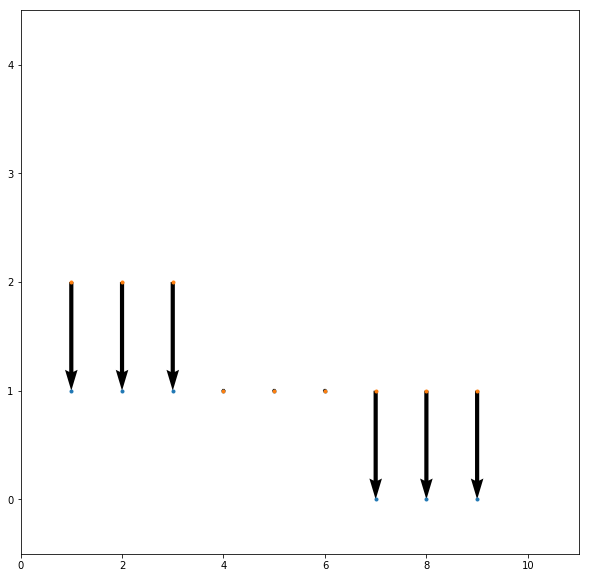

In [37]:
print(gtimer)
sampler.quiver_snodes()

# Replay schedule

In [ ]:
schedule_dict = sampler.find_schedules()
schedule_sorted = sampler.sort_schedule(schedule_dict)
N_fullstep = 500
dt_sim = 0.04
# dt_sim = 0.04
for schedule in schedule_sorted:
    print(schedule)
for schedule, i_s in zip(schedule_sorted[:], range(len(schedule_sorted))):
    traj, end_state, error, success = graph.test_transition(
        sampler.snode_dict[0].state, sampler.snode_dict[0].state, 
        N=10, dt=dt_sim, vel_conv=1e-2, err_conv=5e-4, print_expression=False)
    timer.sleep(0.1)
#     try:
    e = graph.replay(schedule, N=N_fullstep, dt=dt_sim, 
                     vel_conv=1e-3, err_conv=1e-3, error_skip=0)
#     except Exception as e:
#         print(e)

[0, 3, 5, 8]
[0, 3, 5, 9]
[0, 3, 5, 7]

--------------------
3-(('box1', 'bottom_g', 'grip1'), ('box2', 'right_p', 'floor'))

--------------------
5-(('box1', 'left_g', 'grip0'), ('box2', 'right_p', 'floor'))

--------------------
8-(('box1', 'bottom_p', 'goal_bd'), ('box2', 'right_p', 'floor'))

--------------------
3-(('box1', 'bottom_g', 'grip1'), ('box2', 'right_p', 'floor'))


# IK test

In [18]:
bx1 = graph.ghnd.NAME_DICT['box2']

In [20]:
T = bx1.get_tf(joint_list2dict(graph.joints.position, graph.joint_names))

In [21]:
import klampt
from klampt.model import ik
world = klampt.WorldModel()

In [221]:
world.loadElement(URDF_PATH)
robot= world.robot(0)
robot.getID()
robot.link_len = len(robot.getConfig())
robot.link_dict = {}
robot.link_name_list = []
for i_l in range(robot.link_len):
    link = robot.link(i_l)
    lname = link.getName()
    robot.link_dict[lname] = link
    robot.link_name_list.append(lname)
robot.joint_lname_list = [graph.urdf_content.joint_map[jname].child for jname in graph.joint_names]
def joints_to_config(robot, Qjoints):
    Qval = [0]*robot.link_len
    for i_l, lname in zip(range(robot.link_len),robot.link_name_list):
        if lname in robot.joint_lname_list:
            Qval[i_l]=Qjoints[robot.joint_lname_list.index(lname)]
    return Qval

def get_config_joints(robot):
    link_q_dict = {rname: qval for rname, qval in zip(robot.link_name_list, robot.getConfig())}
    return [link_q_dict[lname] for lname in robot.joint_lname_list]

In [222]:
gtimer.tic("test")
joints_to_config(robot, Qjoints)
gtimer.toc("test")

0.052928924560546875

In [235]:
Qjoints = graph.combined_robot.home_pose
robot.setConfig(joints_to_links(robot, Qjoints))

In [224]:
link_name = 'indy0_tcp'
link_tcp = robot.link_dict[link_name]
# obj = ik.objective(link_tcp,R=Rot_rpy([0,0,0]).flatten().tolist(),t=[-0.3,-0.3,0.2])
obj = ik.objective(link_tcp,local=[0.0,0.0,0.0],world=[0,0,0.4])
solver = ik.solver(obj)
print(solver.solve())

True


In [226]:
gtimer.tic("test")
Qsol = get_config_joints(robot)
print(gtimer.toc("test"))
graph.show_pose(Qsol)

0.0500679016113


In [238]:
gtimer.tic("test")
T = get_tf(to_link='indy0_tcp', joint_dict=joint_list2dict(Qsol, graph.joint_names), urdf_content=graph.urdf_content)
link_tcp = robot.link_dict['indy0_tcp']
obj = ik.objective(link_tcp,R=T[:3,:3].transpose().flatten().tolist(),t=T[:3,3].tolist())
# obj = ik.objective(link_tcp,local=[0.0,0.0,0.1],world=[0,0,0.3])
solver = ik.solver(obj)
print(gtimer.toc("test"))
print(solver.solve())
link_q_dict = {rname: qval for rname, qval in zip(robot.link_name_list, robot.getConfig())}
Qsol = [link_q_dict[lname] for lname in joint_lname_list]

0.694990158081
True


In [239]:
graph.show_pose(get_config_joints(robot))

# Simulate traj online

In [28]:
snode_schedule = graph.sampler.find_best_schedule(schedule_sorted)
eplan.update(graph)

with DynamicDetector(eplan.online_names, graph.cam.aruco_map, graph.cam.dictionary, graph.cam.rs_config, graph.cam.T_c12, graph.cam.ref_tuple[1]) as dynamic_detector, \
        RvizPublisher(graph, eplan.online_names) as rviz_pub:
    e_sim = graph.execute_schedule_online(snode_schedule, eplan, control_freq=DEFAULT_TRAJ_FREQUENCY, playback_rate=0.5,
                                  vel_conv=0, err_conv=1e-3, T_step = 100, on_rviz=True, 
                                  dynamic_detector=dynamic_detector, rviz_pub=rviz_pub, obs_K="40")

exit
exit
exit


# Execute traj online

In [29]:
graph.combined_robot.reset_connection([True, True])

connection_list
[True, True]
Connect: Server IP (192.168.0.63)


In [30]:
snode_schedule = graph.sampler.find_best_schedule(schedule_sorted)
eplan.update(graph)

with DynamicDetector(eplan.online_names, graph.cam.aruco_map, graph.cam.dictionary, graph.cam.rs_config, graph.cam.T_c12, graph.cam.ref_tuple[1]) as dynamic_detector, \
        RvizPublisher(graph, eplan.online_names) as rviz_pub:
    e_sim = graph.execute_schedule_online(snode_schedule, eplan, control_freq=DEFAULT_TRAJ_FREQUENCY, playback_rate=0.5,
                                  vel_conv=0, err_conv=1e-3, T_step = 100, on_rviz=False, 
                                  dynamic_detector=dynamic_detector, rviz_pub=rviz_pub, obs_K="40")

Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
exit
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
exit
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
exit
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)


In [31]:
print(gtimer)

init_search: 	18.0 ms/1 = 17.547 ms (17.547/17.547)
move_wait: 	62149.0 ms/11049 = 5.625 ms (0.046/24.686)
update: 	22419.0 ms/7102 = 3.157 ms (1.716/7.618)
rviz: 	234.0 ms/7101 = 0.033 ms (0.018/0.88)
send-robot-0: 	5256.0 ms/3158 = 1.664 ms (0.417/6.479)
send-robot-1: 	15420.0 ms/5112 = 3.016 ms (0.38/23.82)
count-robot-0: 	1367.0 ms/1955 = 0.699 ms (0.377/7.456)
count-robot-1: 	1.0 ms/1 = 0.87 ms (0.87/0.87)



[0, 15000, 0, 50]

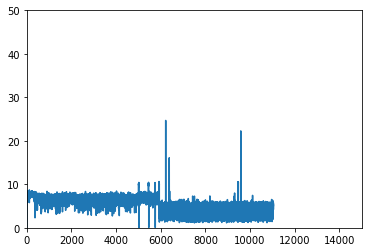

In [40]:
plt.plot(gtimer.timelist_dict["move_wait"])
plt.axis([0,15000,0,50])

[0, 6000, 0, 10]

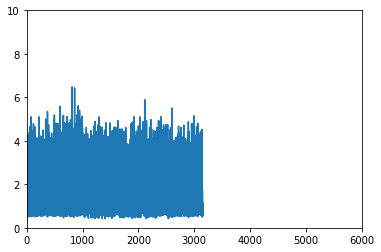

In [41]:
plt.plot(gtimer.timelist_dict["send-robot-0"])
plt.axis([0,6000,0,10])

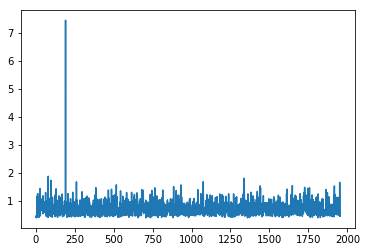

In [47]:
plt.plot(gtimer.timelist_dict["count-robot-0"])
# plt.axis([0,6000,0,10])

[0, 6000, 0, 10]

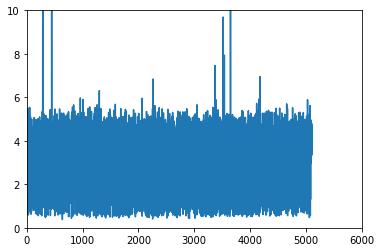

In [43]:
plt.plot(gtimer.timelist_dict["send-robot-1"])
plt.axis([0,6000,0,10])

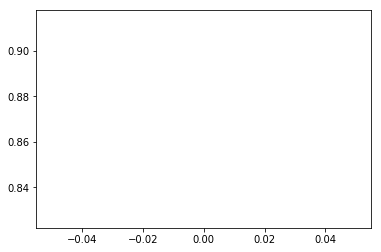

In [46]:
plt.plot(gtimer.timelist_dict["count-robot-1"])
# plt.axis([0,6000,0,20])

# onestep

In [36]:
loop_process = graph
loop_process.stop_now = False
while not loop_process.stop_now:
    print("wait for button input")
    graph.indy.connect_and(graph.indy.wait_di, 16)
    if loop_process.stop_now:
        break
    kn_config, rs_config, T_c12 = calibrate_stereo(aruco_map, dictionary)
    objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = \
        detect_objects(MOVABLE_GENERATORS, aruco_map, dictionary)
    objectPose_dict_mv.update({'floor': objectPose_dict['floor']})
    xyz_rvec_mv_dict, put_point_dict, up_point_dict = calc_put_point(
        objectPose_dict_mv, MOVABLE_GENERATORS, OBJECT_DICT, ("floor", objectPose_dict["floor"]))
    update_geometries(MOVABLE_GENERATORS.keys(), objectPose_dict_mv)
    graph.show_pose(ZERO_JOINT_POSE)

    dt_sim = 0.04
    T_step = 10
    N_fullstep = int(T_step / dt_sim)
    gtimer.reset()
    initial_state = State(tuple([(oname, put_point_dict[oname],'floor') for oname in graph.object_list]), 
                          {oname: graph.object_dict[oname].object.get_offset_tf() for oname in graph.object_list}, 
                          (graph.get_real_robot_pose() if graph.connect_indy and graph.connect_panda 
                           else ZERO_JOINT_POSE))
    binding_dict = match_point_binder(graph, initial_state, objectPose_dict_mv)
    initial_state = State(tuple([(oname, put_point_dict[oname],binding_dict[oname]) for oname in graph.object_list]), 
                          {oname: graph.object_dict[oname].object.get_offset_tf() for oname in graph.object_list}, 
                          (graph.get_real_robot_pose() if graph.connect_indy and graph.connect_panda 
                           else ZERO_JOINT_POSE))
    graph.set_object_state(initial_state)
    graph.show_pose(ZERO_JOINT_POSE)

    goal_nodes_1 = get_goal_nodes(initial_state.node, "box1", "goal_bd")
    goal_nodes = []
    for gnode in goal_nodes_1:
        goal_nodes += get_goal_nodes(gnode, "box2", "floor")
    # goal_nodes = goal_nodes[3:4]

    graph.search_graph_mp(
        initial_state = initial_state, goal_nodes = goal_nodes, swept_volume_test_jmotion=False,
        tree_margin = 2, depth_margin = 2, joint_motion_num=10, 
        terminate_on_first = True, N_search = 100, N_loop=1000,
        display=False, dt_vis=dt_sim/40, verbose = True, print_expression=False, error_skip=0,
        **dict(N=N_fullstep, dt=dt_sim, vel_conv=1e-3, err_conv=1e-3, N_step=N_fullstep))

    schedule_dict = graph.find_schedules()
    schedule_sorted = graph.sort_schedule(schedule_dict)
    print(gtimer)
    schedule_dict = graph.find_schedules()
    schedule_sorted = graph.sort_schedule(schedule_dict)

    schedule = schedule_sorted[0]
    state_schedule = graph.idxSchedule2stateScedule(schedule, ZERO_JOINT_POSE)
    obs_names = ["box3"]

    with DynamicDetector(obs_names, aruco_map, dictionary, rs_config, T_c12, objectPose_dict['floor']) as dynamic_detector, \
            RvizPublisher(graph, obs_names) as rviz_pub:
        graph.execute_schedule_online(state_schedule, control_freq=DEFAULT_TRAJ_FREQUENCY, playback_rate=0.5,
                                      vel_conv=1e-2, err_conv=1e-3, T_step = 100, on_rviz=False, 
                                      obs_names=obs_names, dynamic_detector=dynamic_detector, rviz_pub=rviz_pub)
print("===========================================")
print("=================KILLED====================")
print("===========================================")

wait for button input


AttributeError: 'NoneType' object has no attribute 'connect_and'

In [ ]:
def loop_process():
    loop_process.stop_now = False
    while not loop_process.stop_now:
        print("wait for button input")
        graph.indy.connect_and(graph.indy.wait_di, 16)
        if loop_process.stop_now:
            break
        kn_config, rs_config, T_c12 = calibrate_stereo(aruco_map, dictionary)
        objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = \
            detect_objects(MOVABLE_GENERATORS, aruco_map, dictionary)
        objectPose_dict_mv.update({'floor': objectPose_dict['floor']})
        xyz_rvec_mv_dict, put_point_dict, up_point_dict = calc_put_point(
            objectPose_dict_mv, MOVABLE_GENERATORS, OBJECT_DICT, ("floor", objectPose_dict["floor"]))
        update_geometries(MOVABLE_GENERATORS.keys(), objectPose_dict_mv)
        graph.show_pose(ZERO_JOINT_POSE)
        
        dt_sim = 0.04
        T_step = 10
        N_fullstep = int(T_step / dt_sim)
        gtimer.reset()
        initial_state = State(tuple([(oname, put_point_dict[oname],'floor') for oname in graph.object_list]), 
                              {oname: graph.object_dict[oname].object.get_offset_tf() for oname in graph.object_list}, 
                              (graph.get_real_robot_pose() if graph.connect_indy and graph.connect_panda 
                               else ZERO_JOINT_POSE))
        binding_dict = match_point_binder(graph, initial_state, objectPose_dict_mv)
        initial_state = State(tuple([(oname, put_point_dict[oname],binding_dict[oname]) for oname in graph.object_list]), 
                              {oname: graph.object_dict[oname].object.get_offset_tf() for oname in graph.object_list}, 
                              (graph.get_real_robot_pose() if graph.connect_indy and graph.connect_panda 
                               else ZERO_JOINT_POSE))
        graph.set_object_state(initial_state)
        graph.show_pose(ZERO_JOINT_POSE)

        goal_nodes_1 = get_goal_nodes(initial_state.node, "box1", "goal_bd")
        goal_nodes = []
        for gnode in goal_nodes_1:
            goal_nodes += get_goal_nodes(gnode, "box2", "floor")
        # goal_nodes = goal_nodes[3:4]

        graph.search_graph_mp(
            initial_state = initial_state, goal_nodes = goal_nodes, swept_volume_test_jmotion=False,
            tree_margin = 2, depth_margin = 2, joint_motion_num=10, 
            terminate_on_first = True, N_search = 100, N_loop=1000,
            display=False, dt_vis=dt_sim/40, verbose = True, print_expression=False, error_skip=0,
            **dict(N=N_fullstep, dt=dt_sim, vel_conv=1e-3, err_conv=1e-3, N_step=N_fullstep))

        schedule_dict = graph.find_schedules()
        schedule_sorted = graph.sort_schedule(schedule_dict)
        print(gtimer)
        schedule_dict = graph.find_schedules()
        schedule_sorted = graph.sort_schedule(schedule_dict)

        schedule = schedule_sorted[0]
        state_schedule = graph.idxSchedule2stateScedule(schedule, ZERO_JOINT_POSE)
        obs_names = ["box3"]

        with DynamicDetector(obs_names, aruco_map, dictionary, rs_config, T_c12, objectPose_dict['floor']) as dynamic_detector, \
                RvizPublisher(graph, obs_names) as rviz_pub:
            graph.execute_schedule_online(state_schedule, control_freq=DEFAULT_TRAJ_FREQUENCY, playback_rate=0.5,
                                          vel_conv=0.2e-2, err_conv=1e-3, T_step = 100, on_rviz=False, 
                                          obs_names=obs_names, dynamic_detector=dynamic_detector, rviz_pub=rviz_pub)
    print("===========================================")
    print("=================KILLED====================")
    print("===========================================")
t_loop = Thread(target=loop_process)
t_loop.start()

In [ ]:
loop_process.stop_now=True

In [ ]:
t_loop.is_alive()

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
ax = plt.plot(qcount_indy_list)
ax = plt.plot(qcount_panda_list)
plt.subplot(1,2,2)
ax = plt.plot(looptime_list)
print(gtimer)

# Item handling scripts

## show env image

In [7]:
# screen_size = (1080,1920)
# kn_image_out = draw_objects(color_image, aruco_map, objectPose_dict, corner_dict, *kn_config, axis_len=0.1)
# rs_image_out = draw_objects(rs_image, aruco_map, {k:v for k,v in rs_objectPose_dict.items() if k != 'wall'}, rs_corner_dict, *rs_config, axis_len=0.1)
# kn_image_out_res = cv2.resize(kn_image_out, (rs_image_out.shape[1], rs_image_out.shape[0]))
# image_out = np.concatenate([kn_image_out_res, rs_image_out], axis=1)
# ratio = np.min(np.array(screen_size,dtype=np.float)/np.array(image_out.shape[:2],dtype=np.float))
# image_out_res = cv2.resize(image_out, (int(image_out.shape[1]*ratio), int(image_out.shape[0]*ratio)))
# cv2.imshow("test", image_out_res)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

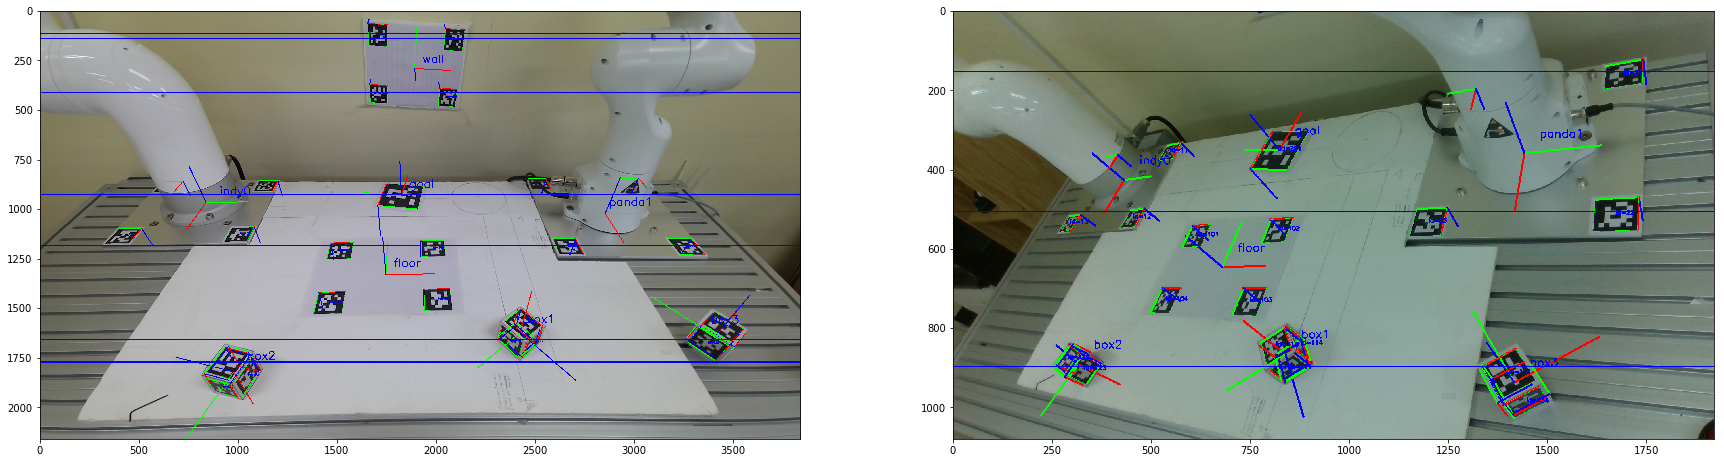

In [8]:
kn_image_out = draw_objects(color_image, aruco_map, objectPose_dict, corner_dict, *kn_config, axis_len=0.1)
rs_image_out = draw_objects(rs_image, aruco_map, {k:v for k,v in rs_objectPose_dict.items() if k != 'wall'}, rs_corner_dict, *rs_config, axis_len=0.1)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(kn_image_out[:,:,[2,1,0]])
plt.subplot(1,2,2)
plt.imshow(rs_image_out[:,:,[2,1,0]])

## Register binders

In [11]:
graph.register_binder(name='grip1', _type=Gripper2Tool, point=[0,0,0.112], link_name="panda1_hand", direction=[0,1,0])
graph.register_binder(name='grip0', _type=Gripper2Tool, point=[0,0,0.14], link_name="indy0_tcp", direction=[0,1,0])
graph.register_binder(name='floor', _type=PlacePlane, direction=[0,0,1])

## detect movable

In [12]:
BINDER_DICT = {'goal_bd': dict(_type=PlacePlane, object_name="goal", point=[0,0,0.02], direction=[0,0,1])}
OBJECT_DICT = {'box1': dict(_type=BoxAction, hexahedral=True),
               'box2': dict(_type=BoxAction, hexahedral=True)}

In [13]:
objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = detect_objects(aruco_map, dictionary)
put_point_dict = graph.register_object_gen(objectPose_dict_mv, BINDER_DICT, OBJECT_DICT, 
                 ref_tuple=(REF_NAME, objectPose_dict[REF_NAME]), link_name="world")

create_safe - box1
new
create_safe - goal
new
create_safe - box3
new
create_safe - box2
new
create_safe - box1_top_p
new
create_safe - box1_bottom_p
new
create_safe - box1_top_g
new
create_safe - box1_bottom_g
new
create_safe - box1_right_p
new
create_safe - box1_left_p
new
create_safe - box1_front_p
new
create_safe - box1_back_p
new
create_safe - box1_right_g
new
create_safe - box1_left_g
new
create_safe - box1_front_g
new
create_safe - box1_back_g
new
create_safe - box2_top_p
new
create_safe - box2_bottom_p
new
create_safe - box2_top_g
new
create_safe - box2_bottom_g
new
create_safe - box2_right_p
new
create_safe - box2_left_p
new
create_safe - box2_front_p
new
create_safe - box2_back_p
new
create_safe - box2_right_g
new
create_safe - box2_left_g
new
create_safe - box2_front_g
new
create_safe - box2_back_g
new


# show markers

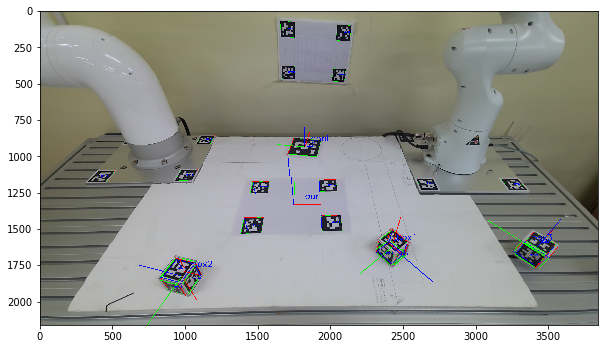

In [14]:
plt.figure(figsize=(10,8))
aruco_map_mv.update({'floor': aruco_map['floor']})
color_image_out = draw_objects(color_image, aruco_map_mv, objectPose_dict_mv, corner_dict_mv, *kn_config, axis_len=0.1)
plt.imshow(color_image_out[:,:,[2,1,0]])

# Register object binders

In [17]:
register_hexahedral_binder(graph, object_name='box1', _type=PlacePlane)
register_hexahedral_binder(graph, object_name='box2', _type=PlacePlane)

generate table - Handle
generate table - Bindergenerate table - Geometry

generate table - Object


# Set ui data

In [16]:
graph.set_rviz(ZERO_JOINT_POSE)
ui_broker.set_tables()

generate table - Handlegenerate table - Geometry

generate table - Binder
 generate table - Object
filname is empty
('saved on :', u'1.geometry')
load: 1.geometry
generate table - Handle
 generate table - Bindergenerate table - Geometry
generate table - Object

filname is empty


# Going back

In [ ]:
e_POS = e_POS_list[0]
self.panda.move_joint_interpolated(
    e_POS[0, graph.panda_idx], N_step=500, N_div=500)

In [ ]:
e_POS = e_POS_list[0]
if hasattr(graph, 'indy'):
    graph.indy.joint_move_to(np.rad2deg(e_POS[0,graph.indy_idx]))

In [ ]:
self.reset_panda()

In [4]:
'x' in [u'x', u'y']

True

## test unavailable binder

In [50]:
from_state = graph.snode_dict[2].state
to_state = from_state.copy()
print(to_state.node)
print(sorted(graph.binder_dict.keys()))

(('box1', 'front_p', 'grip1'), ('box2', 'front_p', 'grip0'))
['box1_back', 'box1_bottom', 'box1_front', 'box1_left', 'box1_right', 'box1_top', 'box2_back', 'box2_bottom', 'box2_front', 'box2_left', 'box2_right', 'box2_top', 'floor', 'goal_bd', 'grip0', 'grip1']


In [47]:
to_state.node = (('box1', 'back_p', 'box2_right'), ('box2', 'front_p', 'grip0'))

In [48]:
traj, new_state, error, succ = graph.test_transition(from_state, to_state, display=True, N=N_fullstep, dt=dt_sim, vel_conv=1e-3, err_conv=1e-3)

===============Unavailable binder====================


# test mesh

In [ ]:
from pkg.gjk import *

In [ ]:
Q1 = ZERO_JOINT_POSE
Q2 = ZERO_JOINT_POSE - 0.1

gtimer.reset()

gtimer.tic("svt")
swept_volume_test(Q1, Q2, graph.fixed_collision_items_list+graph.movable_collision_items_list, 
                  graph.joint_names, graph.urdf_content)
gtimer.toc("svt")

In [ ]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mplot3d

fig = plt.figure(figsize=(15, 5))

idx_col = 205

sub = fig.add_subplot(1, 1, 1, projection="3d")
x, y, z = np.transpose(vtx2_list[idx1_list[idx_col]])
sub.plot(x, y, z, '-o')
x, y, z = np.transpose(vtx2_list[idx2_list[idx_col]])
print(GeometryItem.GLOBAL_GEO_LIST[idx1_list[idx_col]].name)
print(GeometryItem.GLOBAL_GEO_LIST[idx2_list[idx_col]].name)
sub.plot(x, y, z, '-o')
# sub.view_init(0, 90)

In [ ]:
# np.save("vtx_list", vtx_list)
# np.save("radius_list", radius_list)
# np.save("idx1_list", idx1_list)
# np.save("idx2_list", idx2_list)

# test time

In [ ]:
gtimer.reset()
found_vec = []
for _ in range(10):
    objectPose_dict_mv, corner_dict_mv, color_image, aruco_map_mv = \
        detect_objects(MOVABLE_GENERATORS, aruco_map, dictionary)
    objectPose_dict_mv.update({'floor': objectPose_dict['floor']})
    xyz_rvec_mv_dict, put_point_dict, up_point_dict = calc_put_point(
        objectPose_dict_mv, MOVABLE_GENERATORS, OBJECT_DICT, ("floor", objectPose_dict["floor"]))
    update_geometries(MOVABLE_GENERATORS.keys(), objectPose_dict_mv)
    graph.show_pose(ZERO_JOINT_POSE)
    
    dt_sim = 0.04
    T_step = 10
    N_fullstep = int(T_step / dt_sim)
    initial_state = State(tuple([(oname, put_point_dict[oname],'floor') for oname in graph.object_list]), 
                          {oname: graph.object_dict[oname].object.get_offset_tf() for oname in graph.object_list}, 
                          (graph.get_real_robot_pose() if graph.connect_indy and graph.connect_panda 
                           else ZERO_JOINT_POSE))

    goal_nodes = get_goal_nodes(initial_state, "box1", "goal_bd")
    # goal_nodes = goal_nodes[3:4]

    graph.search_graph_mp(
        initial_state = initial_state, goal_nodes = goal_nodes, swept_volume_test_jmotion=True,
        tree_margin = 2, depth_margin = 2, joint_motion_num=20, 
        terminate_on_first = True, N_search = 100, N_loop=1000,
        display=False, dt_vis=dt_sim/40, verbose = True, print_expression=False, error_skip=0,
        **dict(N=N_fullstep, dt=dt_sim, vel_conv=1e-2, err_conv=1e-3, N_step=N_fullstep))

    schedule_dict = graph.find_schedules()
    schedule_sorted = graph.sort_schedule(schedule_dict)
    found_vec.append(len(schedule_sorted)>0)
print(gtimer)

In [ ]:
print("Success rate: {} %".format(np.mean(found_vec)*100))
print(gtimer)

In [ ]:
# SVT CASE
# Success rate: 100.0 %
# show_pose: 	637.0 ms/30 = 21.22 ms (18.16/27.518)
# search_graph_mp: 	99415.0 ms/30 = 3313.844 ms (1712.408/4521.561)
# init_search: 	57.0 ms/30 = 1.908 ms (1.497/7.065)
# score_graph: 	29.0 ms/240 = 0.122 ms (0.086/0.272)
# reset_valid_node: 	14.0 ms/6030 = 0.002 ms (0.001/0.025)
# check_goal: 	4.0 ms/6177 = 0.001 ms (0.0/0.021)
# get_valid_neighbor: 	6.0 ms/540 = 0.011 ms (0.002/3.62)
# add_node_queue_leafs: 	113.0 ms/30 = 3.767 ms (2.884/5.323)
# find_schedules: 	28.0 ms/30 = 0.948 ms (0.604/1.509)
# sort_schedule: 	0.0 ms/30 = 0.01 ms (0.007/0.022)

In [ ]:
# NO SVT CASE
# Success rate: 100.0 %
# show_pose: 	609.0 ms/30 = 20.284 ms (17.837/26.163)
# search_graph_mp: 	96204.0 ms/30 = 3206.813 ms (1566.82/4633.293)
# init_search: 	53.0 ms/30 = 1.753 ms (1.495/2.953)
# score_graph: 	28.0 ms/240 = 0.116 ms (0.088/0.312)
# reset_valid_node: 	14.0 ms/6030 = 0.002 ms (0.001/0.022)
# check_goal: 	4.0 ms/6174 = 0.001 ms (0.0/0.015)
# get_valid_neighbor: 	2.0 ms/540 = 0.004 ms (0.002/0.026)
# add_node_queue_leafs: 	109.0 ms/30 = 3.65 ms (2.816/4.925)
# find_schedules: 	28.0 ms/30 = 0.941 ms (0.617/2.113)
# sort_schedule: 	0.0 ms/30 = 0.01 ms (0.007/0.015)